## **Task 1**
## Installing TinyImagenet because the images in this dataset are approximately 600 by 600 in size.




In [7]:
!pip install tinyimagenet


## Loading the TinyImageNet dataset

In [8]:
from tinyimagenet import TinyImageNet
from pathlib import Path
import numpy as np
import cv2

# Load the training dataset
train_dataset = TinyImageNet(Path("~/.torchvision/tinyimagenet/"), split="train")
val_dataset = TinyImageNet(Path("~/.torchvision/tinyimagenet/"), split="val")


## Extracting classes from each training and validation sets

In [9]:
train_classes = train_dataset.idx_to_words.values()
val_classes = val_dataset.idx_to_words.values()


## How many samples each one of our desired calss has?

In [10]:
desired_classes = ['mashed potato', 'bell pepper', 'alp', 'sewing machine', 'lemon',
                   'banana', 'umbrella', 'volleyball', 'torch', 'mushroom']

def count_desired_samples(dataset, class_mapping, desired_classes):
    desired_class_counts = {class_name: 0 for class_name in desired_classes}
    for _, label in dataset:
        class_names = class_mapping[label]
        for desired_class in desired_classes:
            if desired_class in class_names:
                desired_class_counts[desired_class] += 1
    return desired_class_counts

# Count desired samples in the training and validation datasets
train_desired_class_counts = count_desired_samples(train_dataset, train_dataset.idx_to_words, desired_classes)
val_desired_class_counts = count_desired_samples(val_dataset, val_dataset.idx_to_words, desired_classes)

# Print the counts
print("Training dataset:")
for class_name, count in train_desired_class_counts.items():
    print(f"{class_name}: {count} samples")

print("\nValidation dataset:")
for class_name, count in val_desired_class_counts.items():
    print(f"{class_name}: {count} samples")

Training dataset:
mashed potato: 500 samples
bell pepper: 500 samples
alp: 500 samples
sewing machine: 500 samples
lemon: 500 samples
banana: 500 samples
umbrella: 500 samples
volleyball: 500 samples
torch: 500 samples
mushroom: 500 samples

Validation dataset:
mashed potato: 50 samples
bell pepper: 50 samples
alp: 50 samples
sewing machine: 50 samples
lemon: 50 samples
banana: 50 samples
umbrella: 50 samples
volleyball: 50 samples
torch: 50 samples
mushroom: 50 samples


## From each desired class, 40 samples are allocated for the train set, and 10 samples for the test set. In total, there are 400 and 100 samples for the train set and test set, respectively.

In [11]:
# Create mappings from class names to indices and vice versa
class_to_idx = {class_name: idx for idx, class_names in enumerate(train_classes) for class_name in class_names}
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}
# Initialize lists to store the indices of the images that belong to the desired classes
desired_train_indices = []
desired_test_indices = []
# Iterate over the dataset and add the indices of the desired images to the lists
for idx, (image, label) in enumerate(train_dataset):
    class_name = idx_to_class[label]
    if class_name in desired_classes:
        desired_train_indices.append(idx)

for idx, (image, label) in enumerate(val_dataset):
    class_name = idx_to_class[label]
    if class_name in desired_classes:
        desired_test_indices.append(idx)
import random

# Shuffle the indices
random.shuffle(desired_train_indices)
random.shuffle(desired_test_indices)

# Select the first 40 indices for each class for the training set, and the next 10 indices for the testing set
new_train_indices = []
new_test_indices = []

for class_name in desired_classes:
    class_indices = [idx for idx in desired_train_indices if idx_to_class[train_dataset[idx][1]] == class_name]
    new_train_indices.extend(class_indices[:40])

    class_indices = [idx for idx in desired_test_indices if idx_to_class[val_dataset[idx][1]] == class_name]
    new_test_indices.extend(class_indices[:10])


##  Utilizing generators to construct the dataset, a method that demands less memory. Also, image resizing and normalizing are performed.

In [12]:
import tensorflow as tf
def train_generator():
    for i in new_train_indices:
        image = train_dataset[i][0]
        image = image.resize((600, 600))
        image_array = np.array(image) / 255.0  # Normalizing the image data to [0, 1]
        yield image_array, image_array  # Yielding the image data as both input and target

def test_generator():
    for i in new_test_indices:
        image = val_dataset[i][0]
        image = image.resize((600, 600))
        image_array = np.array(image) / 255.0  # Normalizing the image data to [0, 1]
        yield image_array, image_array  # Yielding the image data as both input and target


# Define the output types and shapes of the generators
output_types = (tf.float32, tf.float32)  # Adjusted to tf.float32 for both output types
output_shapes = ((600, 600, 3), (600, 600, 3))  # Adjusted to match image dimensions for both output shapes


# Convert the generators to TensorFlow datasets
new_train_dataset = tf.data.Dataset.from_generator(train_generator, output_signature=(
    tf.TensorSpec(shape=output_shapes[0], dtype=output_types[0]),
    tf.TensorSpec(shape=output_shapes[1], dtype=output_types[1])
))
new_test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=(
    tf.TensorSpec(shape=output_shapes[0], dtype=output_types[0]),
    tf.TensorSpec(shape=output_shapes[1], dtype=output_types[1])
))

# Use batch to load data in chunks
new_train_dataset = new_train_dataset.batch(32)
new_test_dataset = new_test_dataset.batch(32)


## Designing the architecture of the model, compiling and fitting

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

def autoencoder_model():
    input_img = tf.keras.layers.Input(shape=(600, 600, 3))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    # Adding this layer for size compatibility
    decoded = layers.Cropping2D(cropping=((4, 4), (4, 4)))(decoded)

    autoencoder = models.Model(input_img, decoded)
    return autoencoder

# Instantiate and compile the model
autoencoder = autoencoder_model()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(
    new_train_dataset,
    epochs=10,
    validation_data=new_test_dataset,
)

# Evaluate the model's performance
decoded_imgs = autoencoder.predict(new_test_dataset)

Epoch 1/10
13/13 [==============================] - 59s 2s/step - loss: 0.0785 - val_loss: 0.0527
Epoch 2/10
13/13 [==============================] - 15s 1s/step - loss: 0.0379 - val_loss: 0.0282
Epoch 3/10
13/13 [==============================] - 16s 1s/step - loss: 0.0223 - val_loss: 0.0148
Epoch 4/10
13/13 [==============================] - 15s 1s/step - loss: 0.0175 - val_loss: 0.0168
Epoch 5/10
13/13 [==============================] - 15s 1s/step - loss: 0.0139 - val_loss: 0.0096
Epoch 6/10
13/13 [==============================] - 15s 1s/step - loss: 0.0095 - val_loss: 0.0074
Epoch 7/10
13/13 [==============================] - 15s 1s/step - loss: 0.0079 - val_loss: 0.0070
Epoch 8/10
13/13 [==============================] - 15s 1s/step - loss: 0.0087 - val_loss: 0.0069
Epoch 9/10
13/13 [==============================] - 15s 1s/step - loss: 0.0069 - val_loss: 0.0069
Epoch 10/10
4/4 [==============================] - 2s 457ms/step


## Plotting the train and test loss curve

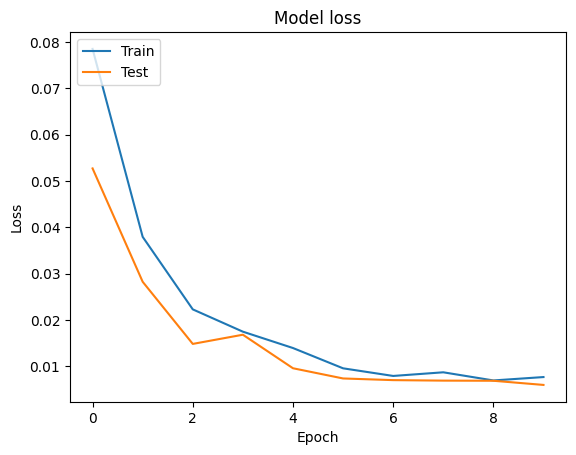

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Plotting original and reconstructed images randomly.

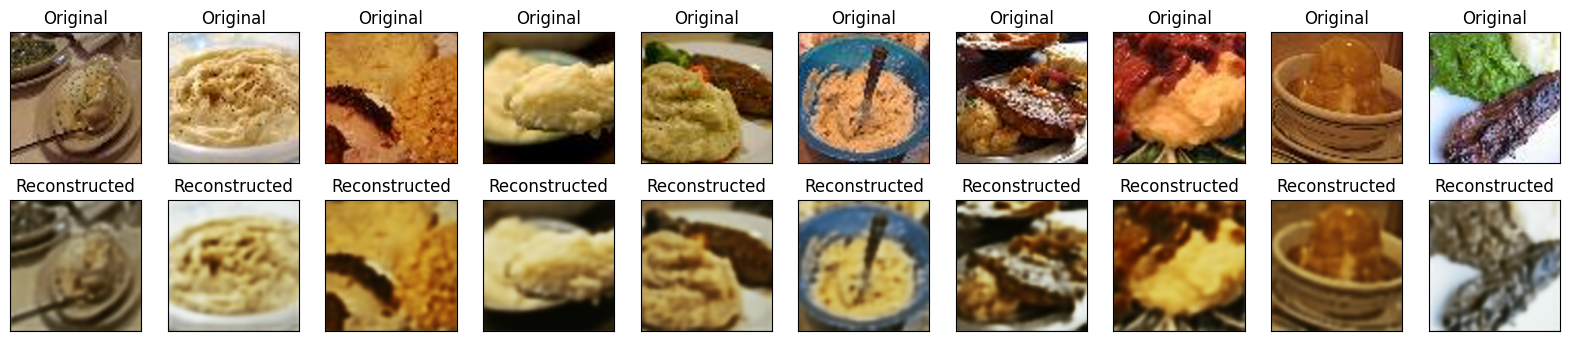

In [17]:


n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

# Ensure that test_image is loaded correctly
for test_image, test_label in new_test_dataset.take(1):
    test_image = test_image.numpy()

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_image[i])  # Assuming test_image is loaded correctly
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original")

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])  # Assuming decoded_imgs is in the correct format
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstructed")

plt.show()  # Display the plot
